In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Förbereder Datasetet

##### 1.1 Laddar upp datan

In [6]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

##### 1.2 Normalisera (VGG gillar värden mellan 0 och 1)

In [7]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

##### 1.3 One-hot encoding

In [8]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print("Data redo för Transfer Learning!")

Data redo för Transfer Learning!


# 2. Ladda den förtränade basmodellen (VGG16)

##### 2.1 Hämtar VGG16

In [9]:
# Vi hämtar VGG16 men sätter include_top=False
# weights='imagenet' betyder att den ska minnas allt den lärt sig från ImageNet-tävlingen.
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(32, 32, 3))

# Visa hur basmodellen ser ut (notera att output inte är 100 klasser än)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# 3. "Frysa" basmodellen

##### 3.1 Frys alla lager i basmodellen

In [10]:
for layer in base_model.layers:
    layer.trainable = False

print("Basmodellen är nu 'fryst' och kommer inte uppdateras under träning.")

Basmodellen är nu 'fryst' och kommer inte uppdateras under träning.


# 4. Bygga den nya modellen

##### 4.1 Tar den frysta modellen och lägger till den sista delen som är anpassad till CIFAR-100 (100 klasser).

In [11]:
model = Sequential()

# Lägg till den förtränade basen först
model.add(base_model)

# Platta till outputen från VGG16 (som är 3D) till 1D
model.add(Flatten())

# Lägg till våra egna klassificeringslager (Detta är vad vi tränar)
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization()) # Alltid bra att ha
model.add(Dropout(0.5))         # Förhindra overfitting

# Sista lagret: 100 neuroner för våra 100 klasser
model.add(Dense(100, activation='softmax'))

# Kompilera modellen
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,872,740 (56.74 MB)

 Trainable params: 157,540 (615.39 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

# 5. Träning (Fine-tuning)

##### 5.1 Träna modellen. Vi kör färre epoker eftersom modellen redan "kan" se bilder.

In [12]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 158ms/step - accuracy: 0.1811 - loss: 3.5479 - val_accuracy: 0.2849 - val_loss: 2.8907
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.2666 - loss: 2.9975 - val_accuracy: 0.3216 - val_loss: 2.7240
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 154s 197ms/step - accuracy: 0.2902 - loss: 2.8696 - val_accuracy: 0.3305 - val_loss: 2.6766
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - accuracy: 0.3026 - loss: 2.7985 - val_accuracy: 0.3363 - val_loss: 2.6455
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - accuracy: 0.3114 - loss: 2.7607 - val_accuracy: 0.3413 - val_loss: 2.6192
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 183ms/step - accuracy: 0.3177 - loss: 2.7274 - val_accuracy: 0.3429 - val_loss: 2.6069
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 183ms/step - accuracy: 0.3211 - loss: 2.7027 - val_accuracy: 0.3474 - val_loss: 2.5964
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 180ms/step - accuracy: 0.3253 -

# 6. Utvärdering och Analys

##### 6.1 Plotta resultaten

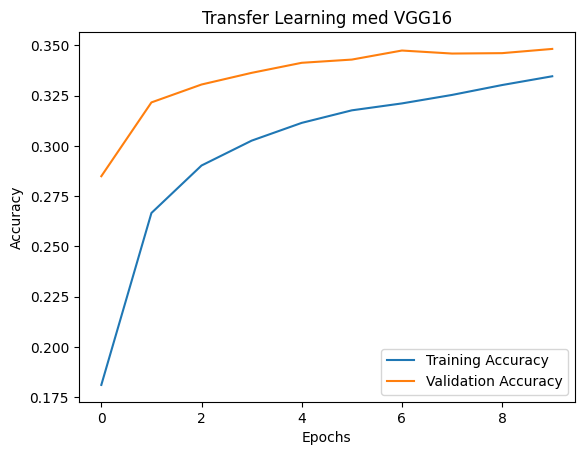

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.3482 - loss: 2.5817
Slutgiltig träffsäkerhet på testdata: 34.82%


In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning med VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Slutgiltig test
loss, acc = model.evaluate(x_test, y_test)
print(f"Slutgiltig träffsäkerhet på testdata: {acc*100:.2f}%")